In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import BlackScholes as bs
import time
import variance_curve as vc
import ImpliedDrift as iD

from rbergomi import rBergomi
from scipy.interpolate import CubicSpline as cs

In [2]:
spot = np.array(pd.read_csv("spot.csv").Spot)
S0 = spot[0]

IV_df = pd.read_csv("hist_spx.csv")
maturities = np.array(IV_df['Exp Date']).flatten()
IV = np.array(IV_df.drop(columns = 'Exp Date'))/100.
period = 0.25

k = np.linspace(0.8, 1.2, 9)
T2 = np.linspace(1, 3, 9)

In [3]:
param = np.array(pd.read_csv("rB_global_parameters2.csv"))[0]

H = param[0]
eta = param[1]
rho = param[2]

In [4]:
def price(S1, S2, k, r, q, T):
    N = len(k)
    p = np.zeros(N)
    for i in range(N):
        p[i] = np.mean(np.maximum(S2 - S1*k[i], 0)) * np.exp(-(r-q)*T)
    return p

In [5]:
def f(tenor, N, n, r, q, S0):
    
    np.random.seed(0)
    
    T = tenor
    
    alpha = H - 0.5

    rB = rBergomi(n, N, T, alpha)

    xi = vc.variance_curve(rB.t[0])

    dW1 = rB.dW1(); dW2 = rB.dW2();
    Ya = rB.Y(dW1)
    dZ = rB.dZ(dW1, dW2, rho)
    V = rB.V(Ya, xi, eta)
    
    return rB.S_all_path(V, dZ, r, q, S0)

In [6]:
iv = list()
points = np.linspace(0.8, 1.2, 1000)

true_start = time.time()

for i in range(len(T2)):
    
    start_time = time.time()
    
    S0 = spot[0]; T = T2[i]; T1 = np.arange(1, (T/period)) * period;
    
    n_period = 250; N = 25000; n = n_period*4;
    r = iD.r(T); q = iD.q(T);
    
    S = f(T, N, n, r, q, S0)
    
    n_aux = len(T1)
    S2 = S[:,-1]
    iv_aux = list()
    
    for j in range(n_aux):
        S1 = S[:, n_period*(j+1)]
        S0 = np.mean(S1)
        rB_v = bs.BSImpliedVol(S0, S0 * k, T-T1[j], r, q, price(S1, S2, k, r, q, T-T1[j]), Option_type = 1, toll = 1e-5)
        iv_aux.append(cs(k, rB_v))
    
    iv.append(iv_aux)    
    print(f'Time elapsed on instance {i}: {time.time()-start_time: .2f}s')

end_time = time.time()
m = np.round((end_time - true_start) / 60)
s = end_time - true_start - 60 * m
print(f'\nTotal elapsed time: {m: .0f}m')

Time elapsed on instance 0:  19.35s
Time elapsed on instance 1:  19.01s
Time elapsed on instance 2:  25.13s
Time elapsed on instance 3:  40.08s
Time elapsed on instance 4:  48.96s
Time elapsed on instance 5:  59.40s
Time elapsed on instance 6:  87.37s
Time elapsed on instance 7:  104.50s
Time elapsed on instance 8:  152.96s

Total elapsed time:  9m


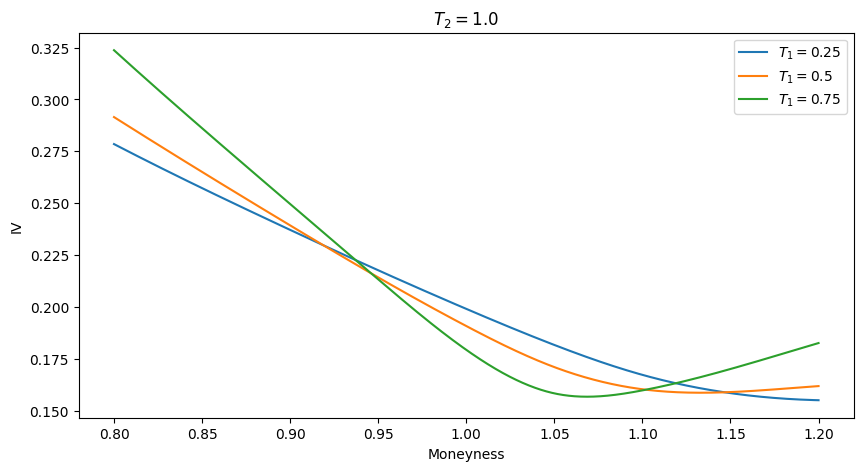

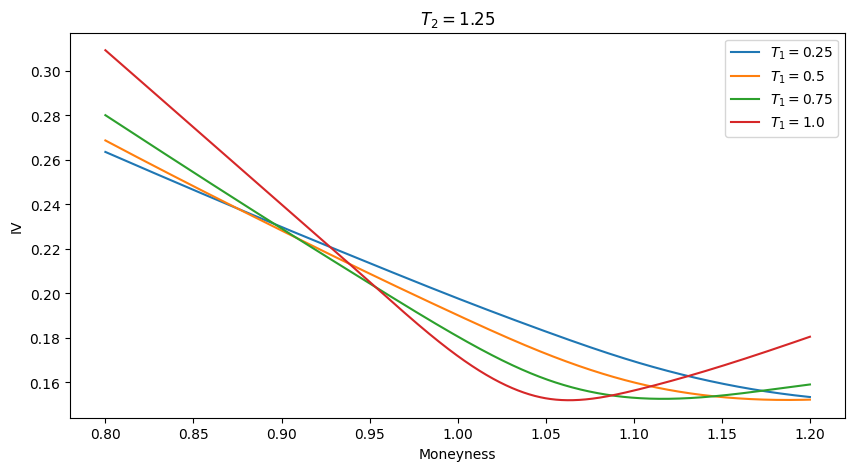

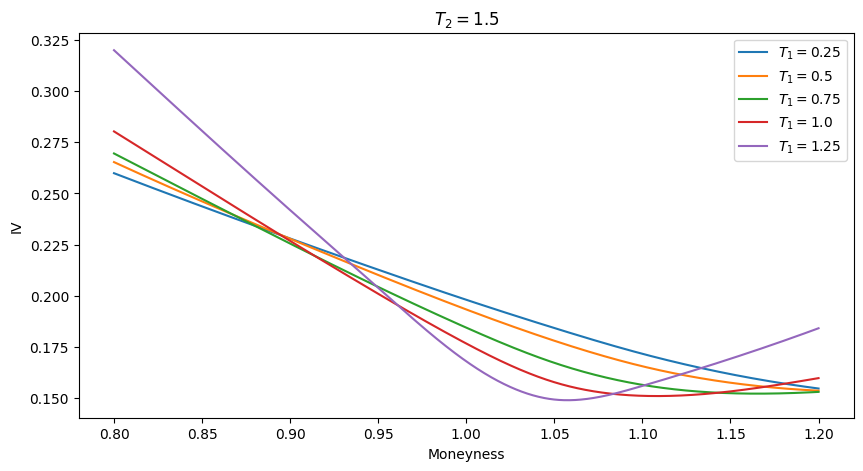

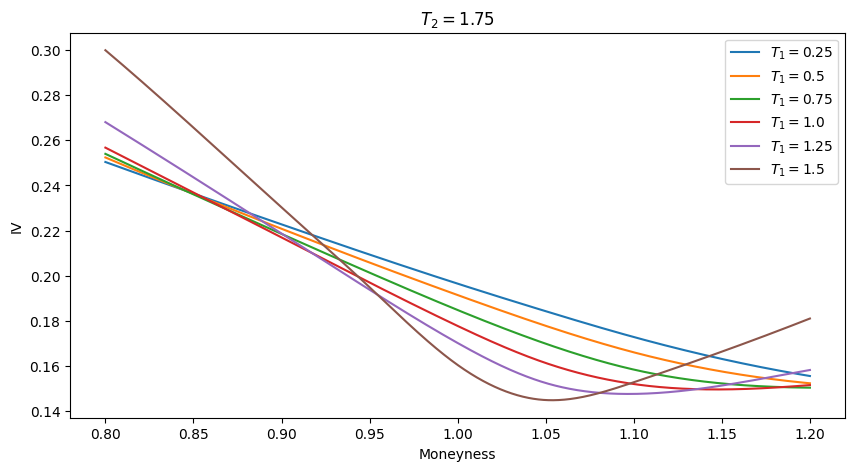

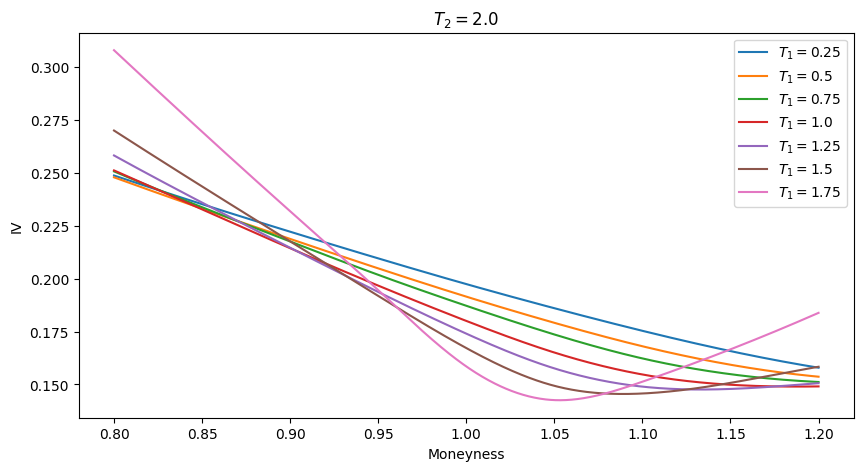

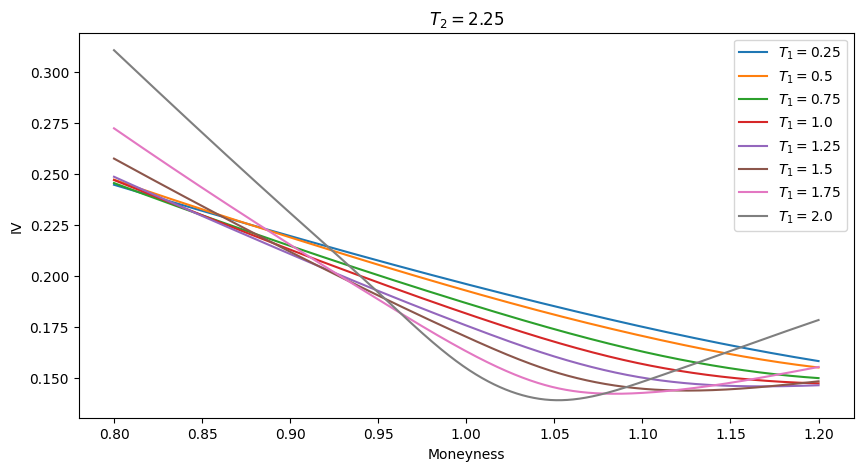

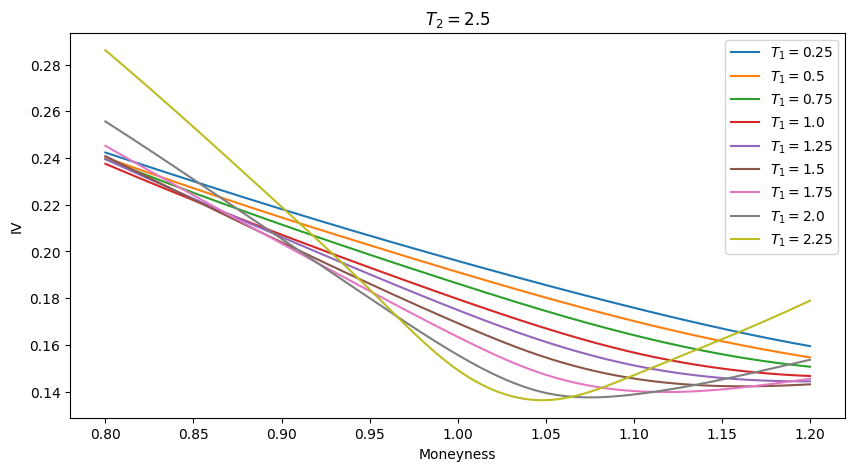

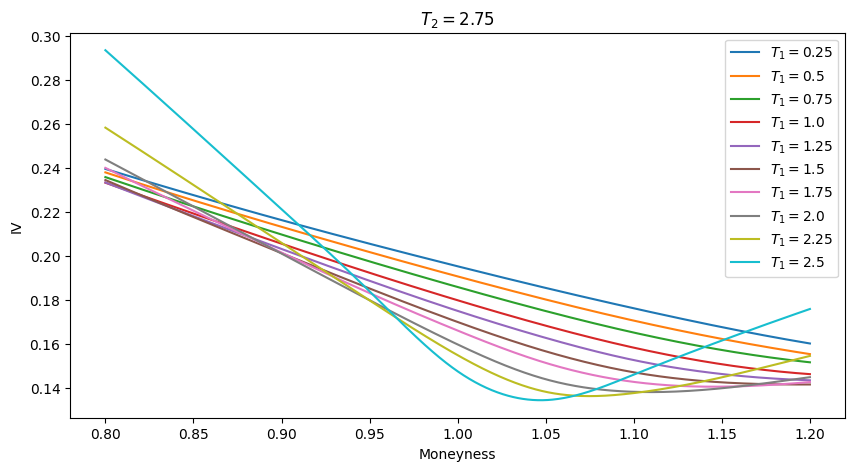

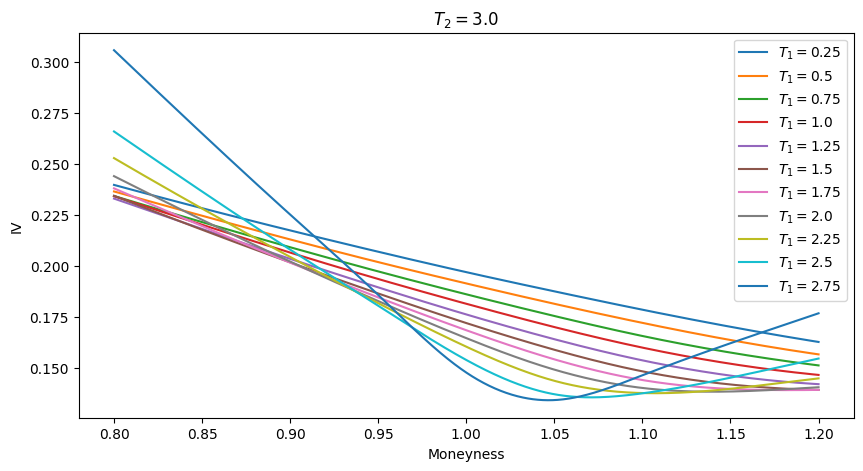

In [7]:
for i in range(len(T2)):
    T = T2[i]
    n = len(iv[i])
    fig = plt.figure(i)
    fig.set_figheight(5)
    fig.set_figwidth(10)
    for j in range(n):
        plt.plot(points, iv[i][j](points))
    plt.title(rf'$T_2 = {T}$')
    plt.legend([rf"$T_1 = {T1[i]}$" for i in range(n)])
    plt.xlabel("Moneyness")
    plt.ylabel("IV")
plt.show()

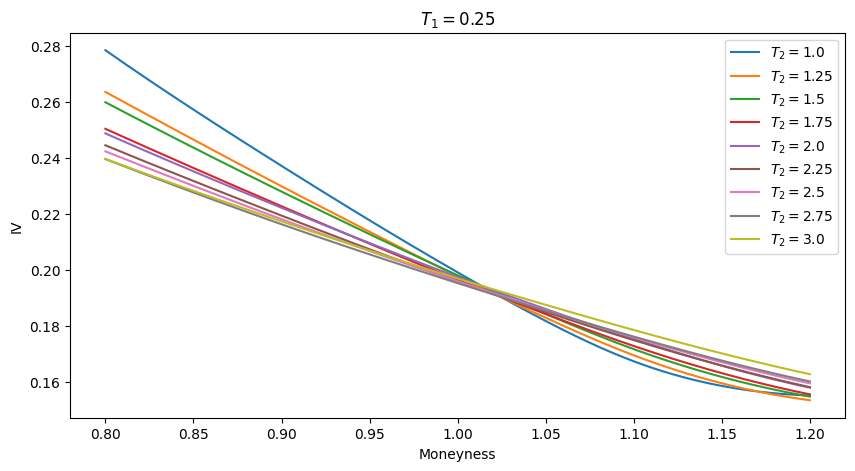

In [8]:
N = len(iv)
fig = plt.figure()
fig.set_figheight(5); fig.set_figwidth(10);

for i in range(N):
    plt.plot(points, iv[i][0](points))
    plt.title(rf'$T_1 = 0.25$')
    plt.legend([rf"$T_2 = {T2[i]}$" for i in range(N)])
    plt.xlabel("Moneyness")
    plt.ylabel("IV")
plt.show()